In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
from cv2 import imread


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ['CUDA_VISIBLE_DEVICE']='-1'
# for dirname, _, filenames in os.walk('/kaggle/input/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
        
training_dataset = '/kaggle/input/writer-handwriting-detection/dataset/dataset/train'

# for dirname,_,filenames in os.walk(training_dataset):
#     for filename in filenames:
#         print(os.path.join(dirname,filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
# specify te shape of the inputs for our network
IMG_SHAPE = (224, 224, 1)
# specify the batch size and number of epochs
BATCH_SIZE = 64
EPOCHS = 100

# Reading validation dataset from val.csv
using pandas 

In [6]:
val_Data = '/kaggle/input/writer-handwriting-detection/dataset/dataset/val.csv'
val_Data = pd.read_csv(val_Data)
val_Data

,img1_name,img2_name,label
0,70a4ba9a.jpg,58f68a00.jpg,1
1,e15b612e.jpg,16ce5df2.jpg,0
2,6c64d988.jpg,735d3636.jpg,1
3,b74681a6.jpg,cb50496d.jpg,0
4,c97aa428.jpg,6f9dc747.jpg,1
...,...,...,...
5765,4e7762f7.jpg,2f3d2bce.jpg,0
5766,c1c49f87.jpg,1072597f.jpg,0
5767,03e66099.jpg,f877b1b6.jpg,1
5768,8e056e51.jpg,f68e79a1.jpg,1


In [7]:
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,MaxPool2D 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow.keras.backend as K

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [8]:

def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
        keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [9]:

def checkval(img):
    result = img.copy()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20,2))
    remove_horizontal = cv2.morphologyEx(thresh , cv2.RETR_EXTERNAL,horizontal_kernel, iterations =2)
    cnts = cv2.findContours(remove_horizontal,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if  len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(result,[c],-1,(255,255,255),5)

    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,20))
    remove_horizontal = cv2.morphologyEx(thresh , cv2.RETR_EXTERNAL,horizontal_kernel, iterations =2)
    cnts = cv2.findContours(remove_horizontal,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if  len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(result,[c],-1,(255,255,255),5)
   

    hsv1 = cv2.cvtColor(result,cv2.COLOR_BGR2HSV)
    lower_black = np.array([0,0,0])
    upper_black = np.array([130,130,130])
    mask = cv2.inRange(hsv1,lower_black,upper_black)
    resultf = cv2.bitwise_and(img,img,mask=mask)
    re = np.count_nonzero(mask)
    return re,img

In [10]:
def fragment_generator(path1,path2):
    img1 = []
    img = imread(path1)
    x,y,_=img.shape
    img= cv2.resize(img,(int((y/x)*224),224),fx=0.3,fy=0.3,interpolation = cv2.INTER_LINEAR)
    for m in range(0,int(y/x)):
        count , image = checkval(img[:,m*224:(m+1)*224,:])
        if (1100 < count < 10000 ):
            gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            img1.append(np.array(gray))
            
    img2 = []
    img = imread(path2)
    x,y,_=img.shape
    img= cv2.resize(img,(int((y/x)*224),224),fx=0.3,fy=0.3,interpolation = cv2.INTER_LINEAR)
    for m in range(0,int(y/x)):
        count , image = checkval(img[:,m*224:(m+1)*224,:])
        if (1100 < count < 10000 ):
            gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            img2.append(np.array(gray))  
    imges = []
    for i in img1:
        for j in img2:
            imges.append([i,j])
    return np.array(imges)
    

In [12]:
model2 = keras.models.load_model("/kaggle/input/finalmodel/final_model_alpha.h5")
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 128)          25088       ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

# Testing

In [49]:
def prediction(model,data,path):
    proba = []
    y_preds = []
    ids = []
    notx = 0
    for i in range(data.shape[0]):
        path1 = path + data.iloc[i]["img1_name"]
        path2 = path + data.iloc[i]["img2_name"]
        ids.append(data.iloc[i]["img1_name"] + "_" + data.iloc[i]["img2_name"])
        image1 = cv2.imread(path1)
        image2 = cv2.imread(path2)
    #     plt.imshow(image1)
    #     plt.show()
    #     plt.imshow(image2)
    #     plt.show()
        img1 = fragment_generator(path1,path2)
        if img1.shape[0] == 0:
            proba.append(0)
            y_pred = [0,0]
            notx += 1
        else:
            y_pred = model.predict([img1[:,0],img1[:,1]])
            proba.append(np.mean(y_pred))

        if(np.mean(y_pred) > .5):
            y_preds.append(1)
        else:
            y_preds.append(0)

        print(i)
    return y_preds,proba,ids,notx

In [ ]:
pathval =  "/kaggle/input/writer-handwriting-detection/dataset/dataset/val/"
y_pred,proba,ids,notx = prediction(model2,val_Data,pathval)
data = {
    "id": ids,
    "proba" : proba
}

df = pd.DataFrame(data)

df.to_csv("result2.csv",index=False)
print(notx)

In [71]:
print(notx)
print(len(proba))
z = list(val_Data['label'])
y_pred = []
for i in proba:
    if i > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
print(len(y_pred))

330
5770
5770


In [72]:
import argparse
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
def plot_auc(y_true, y_proba):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1.05])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')


F1 score: 0.8184
AUC: 0.8474


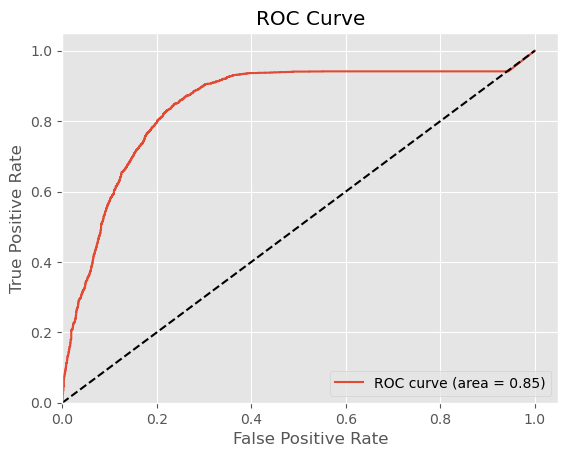

In [73]:
f1_score = f1_score(z, y_pred)
auc = roc_auc_score(z, proba)
plot_auc(z, proba)

print('F1 score: {:.4f}'.format(f1_score))
print('AUC: {:.4f}'.format(auc))

In [ ]:
#val_Data["y_pred"] = y_preds
#val_Data["proba"] = proba

In [ ]:
#val_Data.to_csv("results.csv")

# Dataloader

In [16]:
def make_pairs(images, labels):
    # initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive or negative
    pairImages = []
    pairLabels = []
    
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    minClasses = min(labels)
    maxClasses = max(labels)
    idx = [np.where(labels == i)[0] for i in range(minClasses, maxClasses+1)]
    # loop over all images
    for idxA in range(len(images)):
        # grab the current image and label belonging to the current
        # iteration
        currentImage = images[idxA]
        label = labels[idxA]-minClasses
        # randomly pick an image that belongs to the *same* class
        # label
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]
        # prepare a positive pair and update the images and labels
        # lists, respectively
        pairImages.append([currentImage, posImage])
        pairLabels.append([1])
        
        # grab the indices for each of the class labels *not* equal to
        # the current label and randomly pick an image corresponding
        # to a label *not* equal to the current label
        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]
        # prepare a negative pair of images and update our lists
        pairImages.append([currentImage, negImage])
        pairLabels.append([0])
    # return a 2-tuple of our image pairs and labels
    return (np.array(pairImages), np.array(pairLabels))
    
    

In [17]:
all_writers =[]
datasetx = []
datasety = []
dataset_aspect_ration =[]
datax= []
datay =[]
datap = []
img_data = []
label = []
path = '/kaggle/input/writer-handwriting-detection/dataset/dataset/train'
for i,j in enumerate(os.listdir(path)):
    all_writers.append(os.path.join(path,j))
    

for i,j in enumerate(all_writers):
    d =int(0)
    if i> 300 and i <600:
        for l,k in enumerate(os.listdir(j)):
            image_path = os.path.join(j,k)
            datasetx.append(image_path)
            datasety.append(i)
            img = imread(image_path)
            x,y,_=img.shape
            dataset_aspect_ration.append(y/x)
            datax.append(x)
            datay.append(y)
            datap.append(x*y)
            img= cv2.resize(img,(int((y/x)*224),224),fx=0.3,fy=0.3,interpolation = cv2.INTER_LINEAR)
            for m in range(0,int(y/x)):
                valtochek, imageto = checkval(img[:,m*224:(m+1)*224,:])
                if (1100< valtochek < 10000 ):
                    gray = cv2.cvtColor(imageto,cv2.COLOR_BGR2GRAY)
                    img_data.append(gray)     
                    label.append(i)
                    d = d+1

data = {
    "image_path": datasetx,
    "label": datasety,
    "aspectration": dataset_aspect_ration,
    "x" :datax,
    "y": datay,
    "p" :datap
}

df = pd.DataFrame(data)

df.to_csv("image_path.csv")


img_data = np.array(img_data)
label = np.array(label)





In [18]:
from sklearn.model_selection import train_test_split
 
(img_data, labelTrain) = make_pairs(img_data[:10000,:,:], label[:10000])

img_data, pairTest,labelTrain,labelTest = train_test_split(img_data, labelTrain, test_size=0.2, random_state=0)

# Siemens_network of py or Model1

In [21]:
def build_siamese_network(inputShape,embeddingDim=128):
    # Define the base network (shared weights)
    # specify the inputs for the feature extractor network
    inputs = Input(inputShape)
    #inputs = Rescaling(scale= 1./255 ,offset=0.0)(inputs)
    
    # define the first set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    # second set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    # prepare the final outputs
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)
    # build the model
    model = Model(inputs, outputs)
    return model

In [ ]:
def plot_training(H, plotPath):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

In [ ]:
def Vgg16(IMG_SHAPE):
    model = Sequential()
    model.add(Conv2D(input_shape=IMG_SHAPE,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(units=128,activation="relu"))
    return model

# Second model

In [ ]:
def deepWriter(input_shape):
    # Two different input patches
    patch_1 = Input(shape=input_shape)
    patch_2 = Input(shape=input_shape)

    # Convolution_1 shares the same weight
    conv1 = Conv2D(64, kernel_size=5, strides=2, activation='relu')
    out1 = conv1(patch_1)
    out2 = conv1(patch_2)

    # MaxPooling
    MP = MaxPooling2D(3, strides=2)
    out1 = MP(out1)
    out2 = MP(out2)

    # Convolution_2 shares the same weight
    conv2 = Conv2D(128, kernel_size=3, activation='relu')
    out1 = conv2(out1)
    out2 = conv2(out2)

    # MaxPooling
    out1 = MP(out1)
    out2 = MP(out2)

    # Convolution_3 shares the same weight
    conv3 = Conv2D(128, kernel_size=3, activation='relu')
    out1 = conv3(out1)
    out2 = conv3(out2)

    # Convolution_4 shares the same weight
    conv4 = Conv2D(128, kernel_size=3, activation='relu')
    out1 = conv4(out1)
    out2 = conv4(out2)

    # Convolution_5 shares the same weight
    conv5 = Conv2D(64, kernel_size=3, activation='relu')
    out1 = conv5(out1)
    out2 = conv5(out2)

    # MaxPooling
    out1 = GlobalAveragePooling2D()(out1)
    out2 = GlobalAveragePooling2D()(out2)

    # Flatten
    flat = Flatten()
    out1 = flat(out1)
    out2 = flat(out2)

    # Fully Conneted Layer (FC7)
    FC7 = Dense(128)
    out1 = FC7(out1)
    out2 = FC7(out2)

    # Dropout of 0.5
    out1 = Dropout(0.5)(out1)
    out2 = Dropout(0.5)(out2)
    
   
    # Summation of two outputs
    distance = Lambda(euclidean_distance)([out1, out2])
    outputs = Dense(1, activation="sigmoid")(distance)

    model = Model(inputs=[patch_1, patch_2], outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Making of Model

In [22]:
imgA = Input(shape = IMG_SHAPE) 
imgB = Input(shape = IMG_SHAPE) 
featureExtractor = build_siamese_network(IMG_SHAPE) 
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 1024)         83328       ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

In [23]:
from keras.optimizers import Adam
opt = Adam(lr=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [24]:
img_data.shape

(16000, 2, 224, 224)

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("general.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [26]:
print("[INFO] training model...")
history = model.fit(
    [img_data[:, 0], img_data[:, 1]], labelTrain[:],
    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
    batch_size=30, 
    epochs=10,callbacks=[checkpoint,early])

[INFO] training model...
Epoch 1/10


2023-06-29 15:48:27.770243: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


534/534 [==============================] - 60s 99ms/step - loss: 0.5997 - accuracy: 0.6508 - val_loss: 0.6039 - val_accuracy: 0.6600
Epoch 2/10
534/534 [==============================] - 51s 96ms/step - loss: 0.5532 - accuracy: 0.6881 - val_loss: 0.5975 - val_accuracy: 0.6672
Epoch 3/10
534/534 [==============================] - 50s 94ms/step - loss: 0.5367 - accuracy: 0.7106 - val_loss: 0.5426 - val_accuracy: 0.7130
Epoch 6/10
534/534 [==============================] - 50s 94ms/step - loss: 0.5331 - accuracy: 0.7128 - val_loss: 0.6209 - val_accuracy: 0.6597
Epoch 7/10
534/534 [==============================] - 50s 94ms/step - loss: 0.5336 - accuracy: 0.7164 - val_loss: 0.5297 - val_accuracy: 0.7283
Epoch 8/10
534/534 [==============================] - 50s 94ms/step - loss: 0.5250 - accuracy: 0.7221 - val_loss: 0.5192 - val_accuracy: 0.7333
Epoch 9/10
534/534 [==============================] - 50s 94ms/step - loss: 0.5287 - accuracy: 0.7193 - val_loss: 0.5283 - val_accuracy: 0.7327
Epo

In [ ]:
print("[INFO] plotting training history...")
plot_training(history,'/kaggle/working/')

In [38]:
print("[INFO] saving siamese model...")
model.save('/kaggle/working/final.h5')
# plot the training history


[INFO] saving siamese model...


In [ ]:
score = model.evaluate([img_data[:, 0], img_data[:, 1]], labelTrain[:], verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])